# How to generate a simulated timeline and produce a map with `litebird_sim`

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install .
```

## Set up the environment

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide
import fixpythonpath

We start by importing a few libraries that will be useful in this notebook.

In [2]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from astropy.time import Time

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Produce a simulated timeline


We will simulate 4 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 2 hours of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [3]:
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_004_060_30A_140_T",
    "001_003_000_00A_140_B",
    "001_003_001_00B_140_T",
    "001_003_002_45A_140_B",
]

start_time = Time("2025-01-01T00:00:00")
mission_time_hours = 1

imo_version = "vPTEP"

# Resolution of the input maps
nside = 256

To use the IMO bundled in `litebird_sim`, one needs to do the following:

In [4]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    imo = imo,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

Otherwise, if you want to install the IMO, follow the instructions [in the IMO documentation](https://litebird-sim.readthedocs.io/en/master/imo.html#configuring-the-imo). You can install the IMO with the command `python -m litebird_sim.install_imo` with the [schema.json](https://github.com/litebird/litebird_sim/tree/master/default_imo) in `litebird_sim` or with any other local copy. In this case, use the following:

In [5]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_hours * 3600.0,
    random_seed=12345,
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [6]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    dets.append(det)

Now we set the scanning strategy retriving the parameters from the IMO

In [7]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [8]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

The call above allocated the memory necessary to hold the TOD samples.

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

Before, we set the HWP and then we compute the pointing information that is stored in the observations.

In [9]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [10]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [11]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
    units="K_CMB",
)

mbs = lbs.Mbs(simulation=sim, parameters=Mbsparams, channel_list=ch_info)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2024-04-08 15:58:44,391 INFO MPI#0000] generating and saving cmb simulations
[2024-04-08 15:58:44,436 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:58:44,436 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:58:44,554 INFO MPI#0000] Access data from /home/serenagiardiello/lbs/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_240408.fits
[2024-04-08 15:58:44,555 INFO MPI#0000] NSIDE = 256
[2024-04-08 15:58:44,556 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:44,556 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:44,679 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:58:44,680 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:58:44,692 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:44,692 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:44,692 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2024-04-08 15:58:44,814 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:58:44,815 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:44,815 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:44,816 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:44,939 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:58:44,941 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:44,941 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:44,942 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:46,181 INFO MPI#0000] Retrieve data for pysm_2/ff_t_new.fits (if not cached already)
[2024-04-08 15:58:46,183 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:46,184 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:46,184 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:46,709 INFO MPI#0000] Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
[2024-04-08 15:58:46,710 INFO MPI#000

It's time to fill tods of the observations, with the `signal` we want, in this case CMB and Foreground just generated, dipole (orbital and solar) and noise.

In [12]:
sim.fill_tods(maps)
sim.add_dipole()
sim.add_noise(random=sim.random)

Text(0, 0.5, 'Signal [K]')

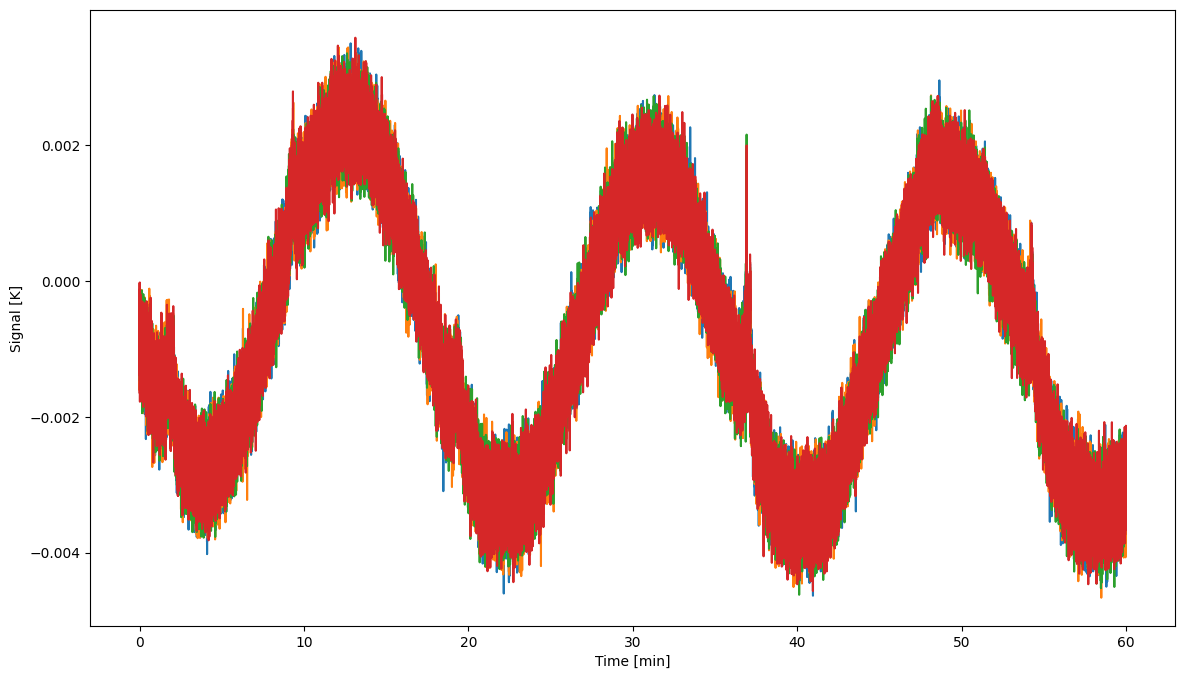

In [13]:
times_min = (
    sim.observations[0].get_times() - sim.observations[0].start_time.cxcsec
) / 60.0
plt.figure(figsize=(14, 8))
plt.plot(times_min, sim.observations[0].tod[0])
plt.plot(times_min, sim.observations[0].tod[1])
plt.plot(times_min, sim.observations[0].tod[2])
plt.plot(times_min, sim.observations[0].tod[3])

plt.xlabel("Time [min]")
plt.ylabel("Signal [K]")

# Produce a simulated map

In this part, instead, we will simulate 2 detectors of 140 GHz MFT. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 1 year of observation at a lower sampling rate for reduce the memory requrements.

In [14]:
telescope = "MFT"
channel = "M1-140"
detlist = [
    "001_004_060_30A_140_T",
    "001_003_000_00A_140_B",
]

start_time = 0
mission_time_days = 365

imo_version = "vPTEP"

# Resolution of the input maps
nside = 256

In [15]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,
)

In [16]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = 1.0  # we reduce the sampling to reduce computation time
    dets.append(det)

In [17]:
# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    nside=nside,
)

mbs = lbs.Mbs(simulation=sim, parameters=Mbsparams, detector_list=dets)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2024-04-08 15:58:51,858 INFO MPI#0000] generating and saving cmb simulations
[2024-04-08 15:58:51,898 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2024-04-08 15:58:51,899 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2024-04-08 15:58:52,008 INFO MPI#0000] Access data from /home/serenagiardiello/lbs/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_240408.fits
[2024-04-08 15:58:52,009 INFO MPI#0000] NSIDE = 256
[2024-04-08 15:58:52,010 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:52,010 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:52,158 INFO MPI#0000] generating and saving fg simulations
[2024-04-08 15:58:52,159 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2024-04-08 15:58:52,160 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:52,161 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:52,161 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2024-04-08 15:58:52,275 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2024-04-08 15:58:52,277 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:52,277 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:52,278 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:52,389 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2024-04-08 15:58:52,390 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:52,390 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:52,391 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:52,549 INFO MPI#0000] Retrieve data for pysm_2/ff_t_new.fits (if not cached already)
[2024-04-08 15:58:52,550 INFO MPI#0000] NSIDE = 512
[2024-04-08 15:58:52,551 INFO MPI#0000] ORDERING = RING in fits file
[2024-04-08 15:58:52,551 INFO MPI#0000] INDXSCHM = IMPLICIT
[2024-04-08 15:58:52,701 INFO MPI#0000] Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
[2024-04-08 15:58:52,703 INFO MPI#000

In [18]:
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,
)

sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

In this case we fill the tods with only CMB, Foreground and white noise.

In [19]:
sim.fill_tods(maps)
sim.add_noise(random=sim.random, noise_type="white")

Then we simply bin the observations into maps.

In [20]:
binner_results = sim.make_binned_map(nside=nside)
binned = binner_results.binned_map

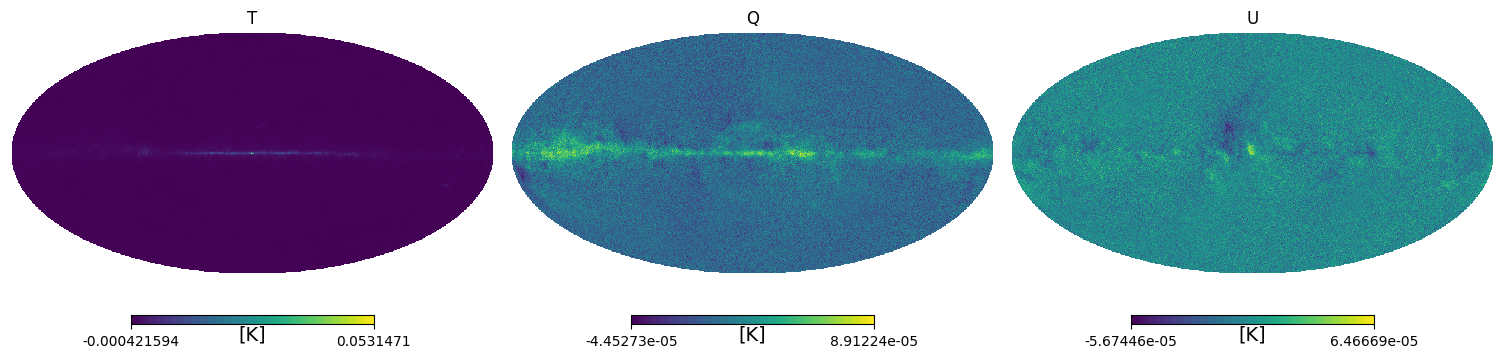

In [21]:
plt.figure(figsize=(15, 8))
hp.mollview(binned[0], sub=131, title="T", unit=r"[K]")
hp.mollview(binned[1], sub=132, title="Q", unit=r"[K]")
hp.mollview(binned[2], sub=133, title="U", unit=r"[K]")